# CS579: Lecture 05  
** Community Detection **

*[Dr. Aron Culotta](http://cs.iit.edu/~culotta)*  
*[Illinois Institute of Technology](http://iit.edu)*

(Many figures come from [Mining of Massive Datasets](http://www.mmds.org/), Jure Leskovec, Anand Rajaraman, Jeff Ullman)

![network](network.png)

- **Why do we want to identify communities?**
- **What are the "communities" in this graph?**
- **Why did you choose these communities?**

<br><br><br><br><br>

**A bad solution: Agglomerative clustering**

- Let distance function $d(A,B)$ be the shortest path between nodes $A$ and $B$
- Let $C_i$ and $C_j$ be two clusters of nodes. Then, let the distance between two clusters be the minimum distance of any two nodes: $d(C_i, C_j) = \min_{X \in C_i, Y \in C_j} \hspace{.1cm} d(X, Y)$
- Greedy agglomerative clustering iterative merges the closest two clusters 

<img width=200 src="https://upload.wikimedia.org/wikipedia/commons/a/ad/Hierarchical_clustering_simple_diagram.svg">

**What would agglomerative clustering do on this network? **

![network](network.png)

$d(A,B) = d(A,C) = d(B, C) = d(B,D) = d(D,E) = d(D,F) = d(D,G) = d(E,F) = d(G,F) = 1$

$d(A,D) = d(C,D) ... = 2$

<br><br><br>
First merge: sample randomly from all nodes with distance == 1.


<br><br><br>
So, $\frac{1}{9}$ chance we merge $B$ and $D$ in first merge.

Not desireable...any other ideas?

What makes the edge between $B$ and $D$ special?

<br><br><br><br>

**Betweenness:** The betweenness of an edge $(A, B)$ is the fraction of shortest paths between any nodes $X$ and $Y$ that include edge $(A, B)$.

High betweenness $\rightarrow$ $A$ and $B$ belong in different communities.

![network](network.png)



What is **betweenness** of $(B,D)$?

<br><br><br><br>

> $(B,D)$ is on all shortest paths connecting any of $\{A,B,C\}$ to any of $\{D,E,F,G\}$.

> Thus, total number of shortest paths = number passing through $(B,D)$ =  $3 * 4 = \mathbf{12}.$. So, $bt(B,D) = 12$


<br><br><br><br>
What is **betweenness** of $(D,F)$?

<br><br><br><br>

> $(D,F)$ is on shortest paths from $\{A,B,C,D\}$ to $\{F\}$.

> Thus, betweenness is $4 * 1 = \mathbf{4}.$



$$
bt(e) =\sum_{s,t \in V} \frac{\sigma(s, t|e)}{\sigma(s, t)}
$$
where

- $V$ is the set of nodes
- $\sigma(s, t)$ is the number of shortest paths between nodes $s$ and $t$
- $\sigma(s, t|e)$ is the number of those paths  passing through some  edge $e$ 

If $s = t$, $\sigma(s, t) = 1$

So, if there are two shortest paths between $s$ and $t$, but only one goes through $e$, betweenness only increases by 0.5.

What is **betweenness** of $(D,G)$?


![between](between3.png)

<br><br><br>

> $(D,G)$ is on one of the two shortest paths from $D$ to $F$ and $E$ to $G$. 

> It is also on the only shortest path from $D$ to $G$.

> Thus, betweenness is $\frac{1}{2} + \frac{1}{2} + 1 = \mathbf{2}.$


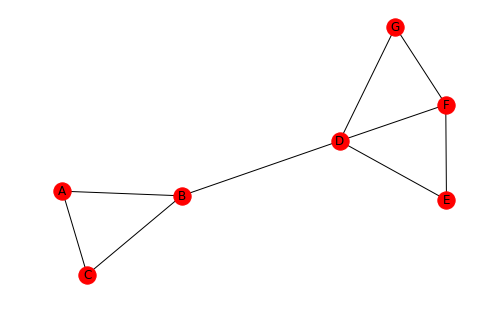

In [2]:
import networkx as nx
%matplotlib inline
def create_example_graph():
    graph = nx.Graph()
    graph.add_edges_from([('A', 'B'), ('A', 'C'), ('B', 'C'),
                          ('B', 'D'), ('D', 'E'), ('D', 'F'),
                          ('D', 'G'), ('E', 'F'), ('G', 'F')])
    return graph

graph = create_example_graph()
nx.draw(graph, with_labels=True)

In [3]:
# We'll use networkx's built-in betweenness computation in this example.
nx.edge_betweenness_centrality(graph, normalized=False)
# nx.edge_betweenness_centrality(graph, normalized=True)
# normalized between 0-1

{('A', 'B'): 5.0,
 ('A', 'C'): 1.0,
 ('B', 'C'): 5.0,
 ('B', 'D'): 12.0,
 ('D', 'E'): 4.5,
 ('D', 'F'): 4.0,
 ('D', 'G'): 4.5,
 ('E', 'F'): 1.5,
 ('F', 'G'): 1.5}

** How to compute shortest path in undirected graph? **

<br><br><br>
<img src="https://upload.wikimedia.org/wikipedia/commons/4/46/Animated_BFS.gif">

[source](https://en.wikipedia.org/wiki/File:Animated_BFS.gif)

** Breadth first search: ** Given a sourse node $s$, compute the shortest paths to each of its neighbors. Proceed

In [4]:
from collections import deque
# double ended queue
# stored as a doubly linked list

q = deque()
q.append(1)
print(q)
q.append(2)
print(q)
q.append(3)
print(q)
print('popleft returns: %d' %  q.popleft())
print(q)
print('pop returns: %d' %  q.pop())
print(q)

deque([1])
deque([1, 2])
deque([1, 2, 3])
popleft returns: 1
deque([2, 3])
pop returns: 3
deque([2])


In [5]:
# compare with:
a = [1,2,3]
print(a.pop(0))
#print(a.pop())
a

1


[2, 3]

**What is running time to remove first element of a dynamic array with $n$ elements (a list in Python)?**

<br><br><br>

$O(n)$: Need to shift all elements to the left.

<br><br><br>

**What is the running time to remove first element of a doubly linked list $n$ elements (a deque in Python)?**

<br><br><br>

$O(1)$

See more:
https://wiki.python.org/moin/TimeComplexity


In [6]:
# Sample implementation of doubly linked list.

class Node:
    def __init__(self, val):
        self.val = val
        self.prev = None # previous node
        self.next = None # next node
        self.head = self
        
    def display(self):
        node = self.head
        vals = []
        while node:
            vals.append(node.val)
            node = node.next
        print(vals)
            
    def popleft(self):
        """
        Remove leftmost element of list.
        """
        v = self.head.val
        self.next.prev = None
        self.head = self.next
        return v
        
n1 = Node(1)
n2 = Node(2)
n3 = Node(3)
n1.next = n2
n2.prev = n1
n2.next = n3
n3.prev = n2

mylist = n1
mylist.display()  
print(mylist.popleft())
print(mylist.popleft())

[1, 2, 3]
1
2


In [19]:
# to get the neighbors of a node:
list(graph.neighbors('A'))
# vs
#graph.neighbors('A')

['B', 'C']

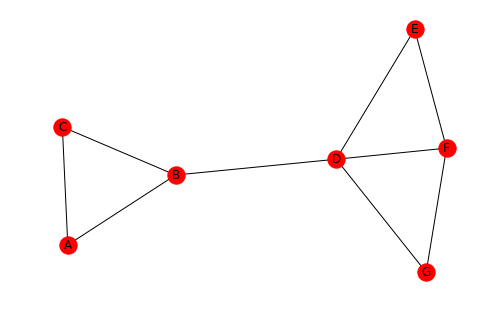

In [11]:
nx.draw(graph, with_labels=True)

In [13]:
def bfs(graph, start):
    """
    Return the order in which nodes are visited in a breadth-first 
    traversal, starting with the given node.
    """
    q = deque()
    q.append(start)
    seen = set()       # nodes we have already visited.
    res = []
    while len(q) > 0:  # while more to visit
        n = q.popleft()
        if n not in seen:
            res.append(n)
            seen.add(n)
        for nn in graph.neighbors(n):
            if nn not in seen:
                q.append(nn)
    return res

bfs(graph, 'D')

['D', 'B', 'E', 'F', 'G', 'A', 'C']

To get all shortest paths from a node, perform BFS, while keeping track of the depth of the search.

In [14]:
for s in graph.nodes():
    paths = nx.single_source_shortest_path(graph, s)
    print('\nshortest paths for %s' % s)
    print(paths)


shortest paths for A
{'A': ['A'], 'B': ['A', 'B'], 'C': ['A', 'C'], 'D': ['A', 'B', 'D'], 'E': ['A', 'B', 'D', 'E'], 'F': ['A', 'B', 'D', 'F'], 'G': ['A', 'B', 'D', 'G']}

shortest paths for B
{'B': ['B'], 'A': ['B', 'A'], 'C': ['B', 'C'], 'D': ['B', 'D'], 'E': ['B', 'D', 'E'], 'F': ['B', 'D', 'F'], 'G': ['B', 'D', 'G']}

shortest paths for C
{'C': ['C'], 'A': ['C', 'A'], 'B': ['C', 'B'], 'D': ['C', 'B', 'D'], 'E': ['C', 'B', 'D', 'E'], 'F': ['C', 'B', 'D', 'F'], 'G': ['C', 'B', 'D', 'G']}

shortest paths for D
{'D': ['D'], 'B': ['D', 'B'], 'E': ['D', 'E'], 'F': ['D', 'F'], 'G': ['D', 'G'], 'A': ['D', 'B', 'A'], 'C': ['D', 'B', 'C']}

shortest paths for E
{'E': ['E'], 'D': ['E', 'D'], 'F': ['E', 'F'], 'B': ['E', 'D', 'B'], 'G': ['E', 'D', 'G'], 'A': ['E', 'D', 'B', 'A'], 'C': ['E', 'D', 'B', 'C']}

shortest paths for F
{'F': ['F'], 'D': ['F', 'D'], 'E': ['F', 'E'], 'G': ['F', 'G'], 'B': ['F', 'D', 'B'], 'A': ['F', 'D', 'B', 'A'], 'C': ['F', 'D', 'B', 'C']}

shortest paths for G
{'G': 

# Girvan-Newman Algorithm

**Input:** Graph $G$; desired number of clusters $k$

**Output:** A hierarchical clustering of nodes, based on edge betweenness

- **While** number of clusters $< k$:
  - Compute the betweenness of all edges in $G$
  - Remove edge with highest betweenness


![between](between.png)

![between2](between2.png)

## Computing betweenness of all edges

- All pairs-shortest-paths, but need to store the paths.
- How can we reduce redundant computation?

## Computing betweenness of all edges

![newman1](newman1.png)

1.) Do breadth-first search starting at node $E$.
  - Each level is length of shortest path from $E$ to that node
  - Edges within the same level cannot be part of a shortest path from $E$ to some target.
  
2.) Label each node by the number of shortest paths that reach it from the root.
  - Start by labeling the root ($E$). Then, each child node is the sum of its parents.
  - E.g., $G = D + F$


## Computing betweenness of all edges

![newman1](newman2.png)

3.) Compute fraction of shortest paths through each edge (bottom up).
  - leaf nodes get credit 1
  - non-leaf nodes get credit of 1 + credits for edges to nodes at level below
  - edges to level above gets credit proportional to fraction of shortest paths that go through it.

E.g. Level 3:
 - $A$ and $C$ are given credit 1 (they are leaf nodes)
 
Level 2:
 - $B$ gets credit $3$ ($A + C + 1$)
   - All shortest paths from  $\{E\}$ to $\{A, B, C\}$ go through B.
 - $G$ gets credit 1 (leaf)


## Computing betweenness of all edges

![newman1](newman3.png)

Level 1 Edges:
 - $D,B$ edge gets all credit from node $B$ (3)
 - $G$ has two parents, so edges $(D,G)$, $(F,G)$ share the credit from $G$
   - From step 1, $D$ and $F$ each have credit 1, so shared equally. $(\frac{1}{1+1} = .5)$
   - What if $D=5$, $F=3$?  $\frac{5}{8}$, $\frac{3}{8}$
    

Level 1 Nodes:
  - $D = 1 + 3 + .5 = 4.5$
  - $F = 1 + .5 = 1.5$

## Computing betweenness of all edges

![newman1](newman3.png)

- What if $D=5$, $F=3$?  


## Computing betweenness of all edges

![newman1](newman3.png)

- What if $D=5$, $F=3$?  
$(D,G) = \frac{5}{8}$, $(F,G) = \frac{3}{8}$

Final steps:

- Repeat for each node as source
- Divide total by 2 (since each shortest path found twice, once in each direction)

![between](between.png)

In [15]:
def girvan_newman(G, depth=0):
    """ Recursive implementation of the girvan_newman algorithm.
    See http://www-rohan.sdsu.edu/~gawron/python_for_ss/course_core/book_draft/Social_Networks/Networkx.html
    
    Args:
    G.....a networkx graph

    Returns:
    A list of all discovered communities,
    a list of lists of nodes. """

    if G.order() == 1:
        return [G.nodes()]
    
    def find_best_edge(G0):
        eb = nx.edge_betweenness_centrality(G0)
        # eb is dict of (edge, score) pairs, where higher is better
        # Return the edge with the highest score.
        return sorted(eb.items(), key=lambda x: x[1], reverse=True)[0][0]

    # Each component is a separate community. We cluster each of these.
    components = [c for c in nx.connected_component_subgraphs(G)]
    indent = '   ' * depth  # for printing
    while len(components) == 1:
        edge_to_remove = find_best_edge(G)
        print(indent + 'removing ' + str(edge_to_remove))
        G.remove_edge(*edge_to_remove)
        components = [c for c in nx.connected_component_subgraphs(G)]

    result = [c.nodes() for c in components]
    print(indent + 'components=' + str(result))
    for c in components:
        result.extend(girvan_newman(c, depth + 1))

    return result

In [16]:
result = girvan_newman(create_example_graph())

removing ('B', 'D')
components=[NodeView(('A', 'B', 'C')), NodeView(('D', 'E', 'F', 'G'))]
   removing ('A', 'B')
   removing ('A', 'C')
   components=[NodeView(('A',)), NodeView(('B', 'C'))]
      removing ('B', 'C')
      components=[NodeView(('B',)), NodeView(('C',))]
   removing ('D', 'E')
   removing ('E', 'F')
   components=[NodeView(('D', 'F', 'G')), NodeView(('E',))]
      removing ('D', 'F')
      removing ('D', 'G')
      components=[NodeView(('D',)), NodeView(('F', 'G'))]
         removing ('F', 'G')
         components=[NodeView(('F',)), NodeView(('G',))]


In [17]:
result

[NodeView(('A', 'B', 'C')),
 NodeView(('D', 'E', 'F', 'G')),
 NodeView(('A',)),
 NodeView(('B', 'C')),
 NodeView(('A',)),
 NodeView(('B',)),
 NodeView(('C',)),
 NodeView(('B',)),
 NodeView(('C',)),
 NodeView(('D', 'F', 'G')),
 NodeView(('E',)),
 NodeView(('D',)),
 NodeView(('F', 'G')),
 NodeView(('D',)),
 NodeView(('F',)),
 NodeView(('G',)),
 NodeView(('F',)),
 NodeView(('G',)),
 NodeView(('E',))]